In [35]:
# import necessary modules
import plotly.graph_objects as go
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
from mpl_toolkits.basemap import Basemap
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.gridspec as gridspec
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

#get the file path for loading, data file is under the same dir with the notebook
filename="20121015_00_ecmwf_ensemble_forecast.PRESSURE_LEVELS.EUR_LL10.120.pl.nc"
foldername="ECWMF Datasets"
filepath=os.path.join(os.path.dirname(os.getcwd()),foldername,filename)

# read the raw data and extract the needed data
# exrtact the value of Geopotential under the pressure of 500 hPA in the certain
Pressure_Levels_data = nc.Dataset(filepath,"r")

# get all the dimension value
nd_1,nd_2,nd_3,nd_4,nd_5 = Pressure_Levels_data.variables['Geopotential_isobaric'][:].shape
# get the necessary raw data
Geopotential_Isobaric_500 = Pressure_Levels_data.variables['Geopotential_isobaric'][0,:,7,:,:] / 9.80655
# reshape the dataset into form of (51,41*101)
Geopotential_Isobaric_500_reshaped = np.reshape(Pressure_Levels_data.variables['Geopotential_isobaric'][0,:,7,:,:],(nd_2, nd_4 * nd_5))
# prepare the longitude and latitude value for contour
longitude = Pressure_Levels_data['lon'][:]
latitude = Pressure_Levels_data['lat'][:]
(lon, lat) = np.meshgrid(longitude, latitude)

# use PCA to reduce dimensions under the condition of reaching 80% of all the member infomation
exp_var = 0
n_pc = 0
while exp_var < 0.8:
    n_pc = n_pc + 1
    pca = PCA(n_components = n_pc)
    pca.fit(Geopotential_Isobaric_500_reshaped)
    exp_var = sum(pca.explained_variance_ratio_)

# get the transformed raw data in the dimension-reduced space    
pca_transformed_data = pca.transform(Geopotential_Isobaric_500_reshaped)

In [187]:
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns

n_samples=150
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
X = noisy_moons[0]

In [160]:
#find the eps automatically according to data and nth
def Get_KNN_Index(data,nth):
    ns = nth
    nbrs = NearestNeighbors(n_neighbors=ns).fit(data)
    distances, indices = nbrs.kneighbors(data)
    distanceDec = sorted(distances[:,ns-1])
    slope=np.array([distanceDec[i]-distanceDec[i-1] for i in range(1,data.shape[0])])
    meanSlope = np.mean(slope)
    stdSlope=np.std(slope)
    for index,n in enumerate(slope):
        if n > meanSlope+stdSlope:
            idx=index
            break
    return distanceDec[idx-1]

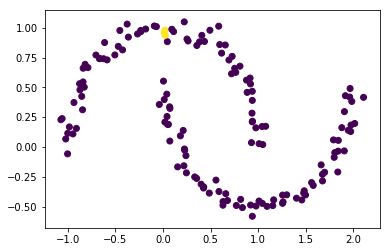

In [194]:
n=3
db = DBSCAN(eps = Get_KNN_Index(X,n), min_samples = n).fit(X)
plt.scatter(X[:,0], X[:,1], c=db.labels_)

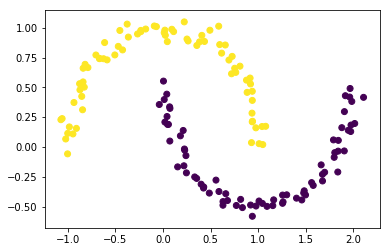

In [193]:
import hdbscan

hdbscanner = hdbscan.HDBSCAN(min_cluster_size=6)
hdbscan_labels = hdbscanner.fit_predict(X)
plt.scatter(X[:,0], X[:,1], c=hdbscan_labels)